In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
from tqdm import tqdm

%matplotlib inline
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data Processing

In [2]:
alphabet_corpus = string.ascii_letters + string.digits
alphabet_corpus_size = len(alphabet_corpus)

In [3]:
def read_file(filename):
    path = os.path.join('./Data/', filename)
    with open(path) as file:
        variable = file.readlines()
    variable = [x.strip() for x in variable]
    return variable

In [4]:
location = read_file('location.txt') + read_file('airport_name.txt')
company = read_file('company_name.txt')
random_string = read_file('random_string.txt')

In [5]:
# location = list(set(location))
# company = list(set(company))[:len(location)]
# random_string = list(set(random_string))
# data = location + company + random_string

In [6]:
size = 10000
location = list(set(location))[:size]
company = list(set(company))[:size]
random_string = list(set(random_string))[:size]
data = location + company + random_string

In [7]:
def data_label(category, representation, input_category):
    for i in range(len(category)):
        if category[i] in input_category:
            pass
        else:
            input_category[category[i]] = representation
    return input_category

In [8]:
input_category = data_label(location, 0, input_category={})
input_category = data_label(company, 1, input_category=input_category)
input_category = data_label(random_string, 2, input_category=input_category)

In [9]:
# input_category = data_label(random_string, 0, input_category={})
# input_category = data_label(company, 1, input_category=input_category)

In [10]:
grouped_data = [(name, label) for name, label in input_category.items()] 

In [11]:
def alphabet_index(alphabet):
    if alphabet_corpus.find(alphabet) != -1:
        index = alphabet_corpus.find(alphabet)
    else:
        raise ValueError('Alphabet not in corpus')
    return index

def alphabet_to_tensor(alphabet):
    tensor = torch.zeros(1, alphabet_corpus_size)
    try:
        tensor[0, alphabet_index(alphabet)] = 1
    except:
        tensor = torch.zeros(1, alphabet_corpus_size)
    return tensor
    
def word_to_tensor(words):
    batch_size = len(words)
    max_sequence = max(len(x) for x in words)
    tensor = torch.zeros(max_sequence, batch_size, alphabet_corpus_size)
    for i, word in enumerate(words):
        for j, alphabet in enumerate(word):
            tensor[j, i, :] = alphabet_to_tensor(alphabet)
    return tensor

In [12]:
training_data, test_data = train_test_split(grouped_data, test_size=0.2, shuffle=True, random_state=42)

In [13]:
training_batch = DataLoader(training_data, batch_size=64, drop_last=True)
test_batch = DataLoader(test_data, batch_size=64, drop_last=True)

# RNN

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=1, nonlinearity='tanh', batch_first=False) 
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_):
        batch_size = input_.shape[1]
        hidden = self.first_hidden(batch_size)
        hiddens, hidden = self.rnn(input_, hidden)
        output = self.linear(hidden)
        return output
    
    def first_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=1, batch_first=False) 
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_):
        batch_size = input_.shape[1]
        hidden = self.first_hidden(batch_size)
        hiddens, (hidden, cell_state) = self.lstm(input_, (hidden, hidden))
        output = self.linear(hidden)
        return output
    
    def first_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [16]:
output_size = 3
hidden_size = 16

In [17]:
def train(word_batch, label_batch):
    word_tensor = word_to_tensor(word_batch)
    labels = label_batch
    optimiser.zero_grad()
    # output = rnn(word_tensor)
    output = lstm(word_tensor)
    loss = criterion(output[0], labels)
    loss.backward()
    optimiser.step()
    return loss.item()

In [18]:
def validation(word_batch, label_batch):
    word_tensor = word_to_tensor(word_batch)
    labels = label_batch
    # output = rnn(word_tensor)
    output = lstm(word_tensor)
    loss = criterion(output[0], labels)
    return loss.item()

In [19]:
train_loss = []
validation_loss = []

In [20]:
total_epoch = 30
lr = 0.01

In [21]:
# rnn = RNN(alphabet_corpus_size, hidden_size, output_size)
# criterion = nn.CrossEntropyLoss()
# optimiser = optim.Adam(rnn.parameters(), lr=lr)

In [22]:
lstm = LSTM(alphabet_corpus_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(lstm.parameters(), lr=lr)

In [23]:
for epoch in tqdm(range(total_epoch)):
    epoch_loss = 0
    val_loss = 0
    for string, label in training_batch:
        # rnn.train()
        lstm.train()
        loss = train(string, label)
        epoch_loss += loss
    epoch_loss = epoch_loss/len(training_batch)
    train_loss.append(epoch_loss)
    
    for string, label in test_batch:
        with torch.no_grad():
            # rnn.eval()
            lstm.eval()
            loss = validation(string, label)
            val_loss += loss
    val_loss = val_loss/len(test_batch)
    validation_loss.append(val_loss)

100%|██████████| 30/30 [11:52<00:00, 23.31s/it]


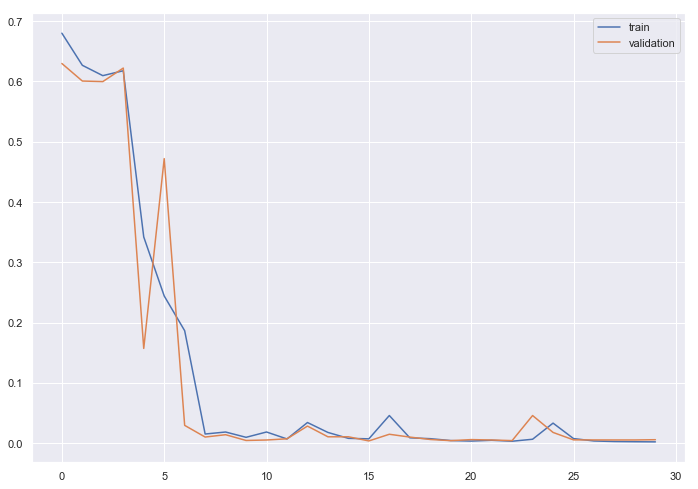

In [24]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.legend(loc='upper right')
plt.show()

In [25]:
def confusion_matrix(category_number):
    return np.zeros((category_number,category_number))

In [26]:
def accuracy_score(confusion_matrix):
    accuracy = 0
    for i in range(len(confusion_matrix)):
        accuracy += confusion_matrix[i,i]
    accuracy = accuracy/sum(sum(confusionMatrix))*100
    return accuracy

In [27]:
predicted_outputs = []
actual_outputs = []
for string, label in test_batch:
    with torch.no_grad():
        # rnn.eval()
        lstm.eval()
        word_tensor = word_to_tensor(string)
        # predicted_output = rnn(word_tensor).argmax(axis=2).tolist()[0]
        predicted_output = lstm(word_tensor).argmax(axis=2).tolist()[0]
        actual_output = label.tolist()
        predicted_outputs += predicted_output
        actual_outputs += actual_output
predicted_outputs = np.array(predicted_outputs)
actual_outputs = np.array(actual_outputs)

In [28]:
# actual row, predict column
confusionMatrix = confusion_matrix(output_size)
for i in range(len(actual_outputs)):
    if actual_outputs[i] == predicted_outputs[i]:
        confusionMatrix[actual_outputs[i],actual_outputs[i]] += 1
    elif actual_outputs[i] != predicted_outputs[i]:
        confusionMatrix[actual_outputs[i],predicted_outputs[i]] += 1

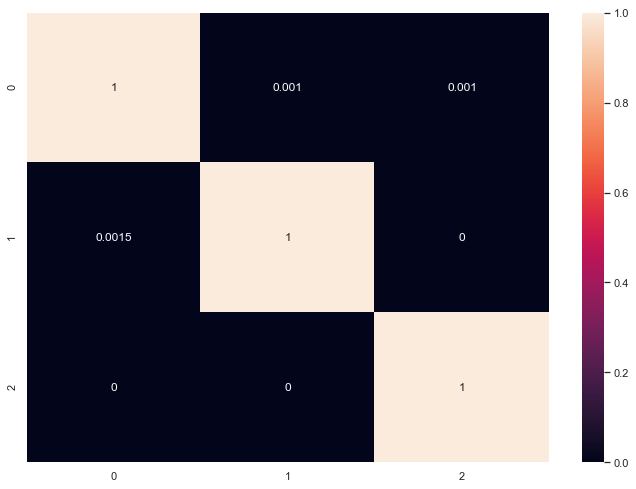

In [29]:
confusionMatrix_norm = confusionMatrix/confusionMatrix.sum(axis=1)
sns.heatmap(confusionMatrix_norm, annot=True)
plt.show()

In [30]:
accuracy_score(confusionMatrix)

99.88239247311827